# Business Overview
## Context
Discussing things you care about can be difficult. The threat of abuse and harassment online means that many people stop expressing themselves and give up on seeking different opinions. Platforms struggle to effectively facilitate conversations, leading many communities to limit or completely shut down user comments.

The Conversation AI team, a research initiative founded by Jigsaw and Google (both a part of Alphabet) are working on tools to help improve online conversation. One area of focus is the study of negative online behaviors, like toxic comments (i.e. comments that are rude, disrespectful or otherwise likely to make someone leave a discussion). 

## Problem
So far they’ve built a range of publicly available models served through the Perspective API, including toxicity. But the current models still make errors, and they don’t allow users to select which types of toxicity they’re interested in finding (e.g. some platforms may be fine with profanity, but not with other types of toxic content).

## Objective
Build a multi-headed model that’s capable of detecting different types of toxicity like threats, obscenity, insults, and identity-based hate better than Perspective’s current models. We'll be using a dataset of comments from Wikipedia’s talk page edits. Improvements to the current model will hopefully help online discussion become more productive and respectful.


# Technical Overview
## Problem
Given a set of comments as input, our model has to predict in which of the following 6 classes each comment is classified:
- Toxic
- Severe toxic
- Obscene
- Threat
- Insult
- Identity_hate

From the train data set, the model has to learn how to classify each comment. Knowing that, the model applies its learning on the test data set to predict the classifications of each comment. 

## Class Properties Assumptions
According to the classes, we cannot answer with exactitude what are the properties that define each class. What are the differences between a comment classified as toxic versus severe toxic? Normally, we would have asked the question to the person that create those classes.

Using the definition of each class, we assume the following definitions:
- Toxic: Only few parts of the comment are using words like fuck, suck or any other similar word.
- Severe toxic: All parts of the comment is toxic and the ratio between bad words like fuck, suck or similar word and the number of words is closer to 1.
- Obscene: All comments containg exagerated abominations or have sexual content.
- Threat: All comments containing menace (severe or simply a warning) to other people or wishing some punishments like insisting on banning someone.
- Insult: All comments insulting other people like telling that someone is stupid, imbecile or any other similar insults.
- Identity_hate: All comments having racist content, sexual orientation hate or religion hate.

These definitions could be used as a set of rules to follow to increase the accuracy of the classification of comments.

## Mathematical Problem Definition
Let $X = (x_1,x_2,\ldots,x_n) \in \mathcal{C}^n$ be the vector of comments where $\mathcal{C}$ is a vector of words $(w_1, w_2, \ldots, w_k)$ defining a comment and $n$ is the length of $X$ which is the number of comments in the data set. The position of the comments in $X$ does not matter.
We note the category vector as $Y = (y_1,y_2,\ldots,y_m) \in \mathbb{M}_{n \times m}([0,1])$ where each of them is predicted by the estimator vector $\hat{Y} = (\hat{y}_1,\hat{y}_2,\ldots,\hat{y}_m) \in \mathbb{M}_{n \times m}([0,1])$ associated to a bias vector $\epsilon = (\epsilon_1, \epsilon_2, \ldots, \epsilon_m) \in \mathbb{M}_{n \times m}([0,1])$. The notation $Y \in \mathbb{M}_{n \times m}([0,1])$ means that $Y$ is a $n \times m$ matrix where each value $y_{i,j}$ is in $[0,1]$. Finally, let $C = (c_1,c_2,\ldots, c_m)$ be the class vector.

Let $f : \mathcal{C}^n \longrightarrow \mathbb{M}_{n \times m}([0,1])$ be a model defined by $f(X) = \hat{Y}$ where $Y = \hat{Y} + \epsilon$ with $+$ the matrix addition operator.
The goal is to find a model $f$ such that the bias $\epsilon$ is minimized when $f$ is applied on $X$.

## Evaluation Metric
We use the __Receiver Operating Characteristic Area Under Curve (ROCAUC)__ function to evaluate the score of the column $i$ noted $R(Y_i, \hat{Y}_i)$. To obtain the multi-class ROCAUC final score, we define the cost function as
$$S(Y, \hat{Y}) = \frac{1}{m} \sum_{i = 1}^m R(Y_i, \hat{Y}_i)$$
where $0 \leq R(Y_i, \hat{Y}_i) \leq 1$ is the ROCAUC function.

The goal is to maximize $S(Y, \hat{Y})$ where $S(Y, \hat{Y}) = 1$ means that the model is perfect. 


# Data Acquisition
The goal is to get the train and test data sets and extract basic information before starting the data exploratory phase.

## Data Source
The data come from Kaggle and are downloaded __[here](https://www.kaggle.com/c/jigsaw-toxic-comment-classification-challenge/data)__.

## Dataset Basic Information
We need to know how much data do we have in our data sets to help us determining a list of algorithms that will suit better to solve the problem.
- Number of rows
- Number of columns
- Percentage: number of rows of a data set / total number of rows of test + train sets * 100
- Average, Min and Max length of comments (number of words and number of characters)

In [1]:
import pandas
import numpy as np
import seaborn as graph
import matplotlib.pyplot as plt
import itertools
import re
import time

from string import punctuation

from IPython.display import display

#from nltk.corpus import stopwords
#from nltk import word_tokenize

from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.linear_model import SGDClassifier
import xgboost as xgb
from sklearn.ensemble import RandomForestClassifier

from sklearn.calibration import CalibratedClassifierCV
#from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve

from PlotUtils import *
from Model import *
from NewFeatureGenerator import *
from DataExploratory import *

## Remove the scientific notation.
np.set_printoptions(suppress=True)
pandas.set_option('display.float_format', lambda x: '%.9f' % x)


train = pandas.read_csv("dataset/train.csv")
train_number_of_rows = len(train.index)
train_number_of_cols = len(train.columns)
print("Train set - Number of rows: ", train_number_of_rows)
print("Train set - Number of columns: ", train_number_of_cols)

test = pandas.read_csv("dataset/test.csv")
test_number_of_rows = len(test.index)
test_number_of_cols = len(test.columns)
print("\nTest set - Number of rows: ", test_number_of_rows)
print("Test set - Number of columns: ", test_number_of_cols)

number_of_classes = train_number_of_cols - test_number_of_cols
print("\nNumber of output classes: ", number_of_classes)

output_classes = train.columns.values[test_number_of_cols:]
print("Output classes: ", output_classes)

train_input = train[train.columns[0:test_number_of_cols]]
train_output = train[output_classes]

percentage_test = round(test_number_of_rows / (test_number_of_rows + train_number_of_rows) * 100, 2)
print("The test set contains ", percentage_test, "% of the overall data sets.")

words_frequency = GetWordFrequency(train.comment_text)
print("Number of unique words: ", len(words_frequency))

lengths = train.comment_text.str.len()
print("\nLength of the smallest comment: ", lengths.min())
print("Length of the largest comment: ", lengths.max())
print("Average length of comments: ", lengths.mean())
print("Standard deviation of the length of comments: ", lengths.std())

Train set - Number of rows:  159571
Train set - Number of columns:  8

Test set - Number of rows:  153164
Test set - Number of columns:  2

Number of output classes:  6
Output classes:  ['toxic' 'severe_toxic' 'obscene' 'threat' 'insult' 'identity_hate']
The test set contains  48.98 % of the overall data sets.
Number of unique words:  470340

Length of the smallest comment:  6
Length of the largest comment:  5000
Average length of comments:  394.0732213246768
Standard deviation of the length of comments:  590.7202819048919


## Applicable Algorithms
The goal is to find a list of algorithms that can be applied to our problem.
- We know the possible outputs where each comment has to be classified hence we seek for a supervised algorithm.
- As the problem states, the output is a multi-classification which explain why the multi-class AUROC metric has been chosen.
- We have to analyse comments (texts) that is part of the Natural Language Processing (NLP). 
- We have 159571 comments in the train set which is a small data set.

According to those points, supervised algorithms for classification related to the NLP are mostly suitable to solve the problem. However, regression algorithms for classification should work because we can extract features from the comments. This will be explained with more details in the Feature Extraction section of this document.

We will try the following algorithms:
- Naive Bayes Classification (NB): https://web.stanford.edu/class/cs124/lec/naivebayes.pdf
- Support Vector Machine (SVM): https://www.analyticsvidhya.com/blog/2017/09/understaing-support-vector-machine-example-code/
- Maximum Entropy Classifier (http://www.kamalnigam.com/papers/maxent-ijcaiws99.pdf)
- Recurrent Convolutional Neural Networks (http://www.aaai.org/ocs/index.php/AAAI/AAAI15/paper/download/9745/9552)

# Data Exploratory
The goal is to explore the training and test sets to understand and visualize how the comments are written and how they are classified.

Comments can be written the following ways knowing that emotions are generally a strong factor that influances how people write their comments:
- Normal sentences without any of the previous ways specified above
- Lower case or upper case. We need to check if this has influance on the classification
- Invisible characters like tabulations, carriage returns, spaces 
- Words with repeated characters (e.g. suckkkkkkkk)
- Abusive usage of puctuation like !?
- Unicode special characters like Chinese characters or any other languages using caligraphic characters
- Words with grammar, spelling or typing errors like the word "btich" which should be "bitch"
- Abbreviations 
- Words written as they sound (e.g. "you" is written "u")
- Bad words hidden like "sh*t"
- Other special characters (e.g. &%?/"!)
- Words with same meaning (e.g. fuck, fucking, fucker)
- Numbers

## Not Applicable or Null Comments
Let's check if there are comments containing NA or being empty.


In [2]:
print("Number of empty comments in train set: ", len(train[train['comment_text'].isnull()]))
print("Number of empty comments in test set: ", len(test[test['comment_text'].isnull()]))

train.comment_text.fillna("unknown", inplace=True)
test.comment_text.fillna("unknown", inplace=True)
print("Number of NA in comments of train set: ", len(train[train['comment_text'] == 'unknown']))
print("Number of NA in comments of test set: ", len(test[test['comment_text'] == 'unknown']))

Number of empty comments in train set:  0
Number of empty comments in test set:  0
Number of NA in comments of train set:  0
Number of NA in comments of test set:  0


We conclude that there are neither NA nor null values in both data sets. 

## Classification of Comments


 Number of comments for each class: 
 toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64


[Text(0,0,'toxic'),
 Text(0,0,'severe_toxic'),
 Text(0,0,'obscene'),
 Text(0,0,'threat'),
 Text(0,0,'insult'),
 Text(0,0,'identity_hate')]

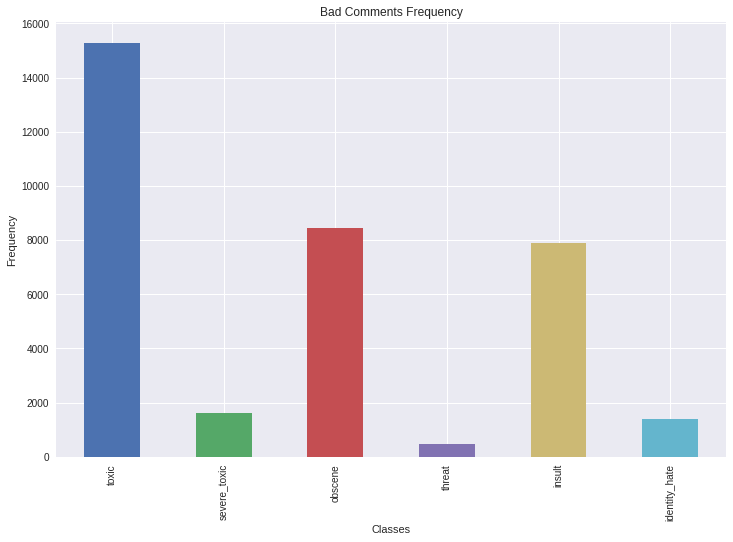

In [3]:
classes_frequency = pandas.Series.from_array(train[output_classes].sum())
print("\n Number of comments for each class: \n", classes_frequency)

plt.figure(figsize=(12, 8))
ax = classes_frequency.plot(kind='bar')
ax.set_title("Bad Comments Frequency")
ax.set_xlabel("Classes")
ax.set_ylabel("Frequency")
ax.set_xticklabels(output_classes)

## Assumptions
1. Upper case words are mostly subject to bad comments.
2. Abusive invisible characters are there to dissimulate bad comments. This is a way to write an inappropriate comment and try to bypass the algorithm to not get blocked.
3. Words containing abusive repeated characters means frustration and are mostly bad.
4. Abusive usage of exclamation marks normally means that people are angry and the risks of containing bad comment are high.
5. Special characters like 'sh*t' hide bad words and are mostly in bad comments.
6. Smaller comments (less than 10 words) are mostly bad comments because people may write sentences like 'Fuck u'.
7. Foreign languages using caligraphic unicode characters (e.g. Chinese characters) are used to hide bad comments because they use their language to not be recognized.
8. Numbers are used to dissimulate a bad word like "5h1t" but it should be a rare case.
9. Repeated words or sentences are mostly used in bad comments.

## Feature Extraction
Let's add new features to the train set according to the assumptions to show if those assumptions are true or false. To prove if they are true or false, we will check the correlation between the new features and the classes. 

,identity_hate,insult,obscene,severe_toxic,threat,toxic
comment_length,-0.013646812,-0.045052165,-0.042944845,0.010131476,-0.008010929,-0.054470061
number_of_capitals,0.053576196,0.075944701,0.081690524,0.143410057,0.033581380,0.091174923
ratio_capitals_length,0.093725789,0.170383907,0.182451738,0.169242883,0.055596134,0.220777185
exclamation_marks,0.006004905,0.027010069,0.024361887,0.060577965,0.034202172,0.037336753
ratio_exclamation_marks_length,0.039348852,0.102696574,0.108243169,0.093135949,0.037812460,0.132070566
question_marks,-0.000516349,0.004858674,0.005404492,-0.004540922,-0.003949309,0.027820112
ratio_question_marks_length,0.000794396,0.010765304,0.014391032,0.000715929,-0.005940034,0.031023651
carriage_returns,0.002479304,-0.008844677,-0.002749310,0.019784200,-0.000248372,-0.010433779
ratio_carriage_returns_length,0.026409986,0.074650203,0.080759894,0.049831116,0.021215112,0.082218584
special_chars,0.013767673,0.007175059,0.015846232,0.016189399,0.002421710,0.017097496


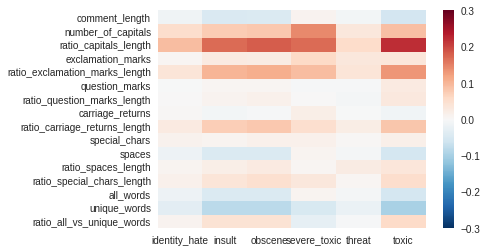

In [4]:
## Assumption 1      
train['comment_length'] = [comment_length for comment_length in comment_lengths(train['comment_text'])]

train['number_of_capitals'] = [capitals for capitals in comments_capitals_counter(train['comment_text'])]

train['ratio_capitals_length'] = [ratio for ratio in ratio_feature_vs_length(train['number_of_capitals'], train['comment_length'])]


## Assumption 2
train['carriage_returns'] = [carriage_returns for carriage_returns in comments_chars_counter(train['comment_text'], '\n\r')]

train['ratio_carriage_returns_length'] = [ratio for ratio in ratio_feature_vs_length(train['carriage_returns'], train['comment_length'])]

train['spaces'] = [spaces for spaces in comments_char_counter(train['comment_text'], ' ')]

train['ratio_spaces_length'] = [ratio for ratio in ratio_feature_vs_length(train['spaces'], train['comment_length'])]


## Assumption 3


## Assumption 4
train['exclamation_marks'] = [exclamation_marks for exclamation_marks in comments_char_counter(train['comment_text'], '!')]

train['ratio_exclamation_marks_length'] = [ratio for ratio in ratio_feature_vs_length(train['exclamation_marks'], train['comment_length'])]

train['question_marks'] = [question_marks for question_marks in comments_char_counter(train['comment_text'], '?')]

train['ratio_question_marks_length'] = [ratio for ratio in ratio_feature_vs_length(train['question_marks'], train['comment_length'])]


## Assumption 5
train['special_chars'] = [special_chars for special_chars in comments_chars_counter(train['comment_text'], '#*$')]

train['ratio_special_chars_length'] = [ratio for ratio in ratio_feature_vs_length(train['special_chars'], train['comment_length'])]


## Assumption 9
train['all_words'] = [all_words for all_words in all_words_counter(train['comment_text'])]

train['unique_words'] = [unique_words for unique_words in unique_words_counter(train['comment_text'])]

train['ratio_all_vs_unique_words'] = [ratio for ratio in ratio_feature_vs_length(train['unique_words'], train['all_words'])]



new_features = ['comment_length', 'number_of_capitals', 'ratio_capitals_length', 
                'exclamation_marks', 'ratio_exclamation_marks_length', 'question_marks', 'ratio_question_marks_length',
                'carriage_returns', 'ratio_carriage_returns_length', 'special_chars', 'spaces',
                'ratio_spaces_length', 'ratio_special_chars_length', 'all_words', 'unique_words', 
                'ratio_all_vs_unique_words']

rows = [{column:train[feature].corr(train[column]) for column in output_classes} for feature in new_features]
train_correlations = pandas.DataFrame(rows, index=new_features)


## Print a data frame in a more esthetic table.
display(train_correlations)

## Visualize the correlation with a heatmap.
graph.heatmap(train_correlations, vmin=-0.3, vmax=0.3, center=0.0)

Let $-1 \leq r(x,y) \leq 1$ be the correlation coefficient where $x$ is the new feature and $y$ the class. If $x$ increases, $y$ increases if and only if $r(x,y) > 0$. If $x$ increases, $y$ decreases if and only if $r(x,y) < 0$. In our case, if the value of the new feature is increased, we want to know if each class $y$ will be most suitable to be classified. Therefore, we search for all new feature $x_i$ such that $r(x_i, y_j) > 0$ (mostly closest to 1).

According to the heatmap and corrolation table, we see that the following new features are subject to bad comments in order of importance:
- ratio between the number of capital letters and the length of comments;
- ratio between the number of exclamation marks and the length of comments;
- Number of exclamation marks;
- Special characters like '*\$#';
- ratio between the number of special characters and the length of comments;
- ratio between the number of carriage returns and the length of comments;
- ratio between the number of words and the number of unique words in each comment.

However, we also search for features $x_i$ such that $r(x_i, y_j) < 0$. Indeed, we assume that if the comment length decreases, then the probability of having a bad comment increases. In that case, we search for $r(x_i, y_j) < 0$. This assumption holds for the following new features for the same reason as the comment length:
- Small comment length;
- Number of unique words
- Number of words per comment

Therefore, we drop features that are useless (mostly new features $x_i$ such that $r(x_i, y_j) \approx 0$).

In [5]:
remove_features = ['spaces', 'special_chars', 'question_marks', 'ratio_special_chars_length']
new_features = [feature for feature in new_features if feature not in remove_features]
train.drop(remove_features, axis=1, inplace=True, errors = 'ignore')

## Relationship Between Classes
We want to check if there is a strong relationship between the classes. The correlation table should show a stronger relationship if $R^2$ is closer to $1$. This could reduce the number of classes because if we find a strong correlation between 2 classes (A and B), we know that we can create a new class in function of A and B.

,toxic,severe_toxic,obscene,threat,insult,identity_hate
toxic,1.000000000,0.308619097,0.676514523,0.157058409,0.647518127,0.266009382
severe_toxic,0.308619097,1.000000000,0.403014456,0.123601289,0.375807151,0.201600209
obscene,0.676514523,0.403014456,1.000000000,0.141179025,0.741272436,0.286866868
threat,0.157058409,0.123601289,0.141179025,1.000000000,0.150022409,0.115128331
insult,0.647518127,0.375807151,0.741272436,0.150022409,1.000000000,0.337736254
identity_hate,0.266009382,0.201600209,0.286866868,0.115128331,0.337736254,1.000000000


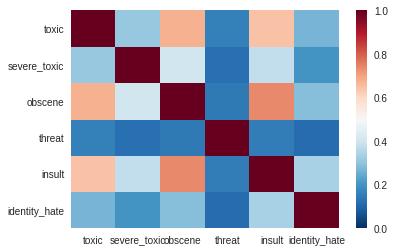

In [6]:
train_output_correlations = train_output.corr()
display(train_output_correlations)
graph.heatmap(train_output_correlations, vmin=0, vmax=1, center=0.5)

As we can see from the heatmap and the corrolation table, 
- Obscene and Insult ($r = 0.741$)
- Obscene and Toxic ($r = 0.677$)
- Insult and Toxic ($r = 0.648$)

have the strongest relationships. We need to know if the $R^2$ is enough close to $1$ to search for a new feature to combine these classes.

## Data Set Cleaning
The goal is to remove noisy words because these words will hinder an accurate prediction.

- Comments contain noise like the words "the", "a", "I", "in", "do" and many others where their frequency should be the highest among the words used in the English language.
- We need to remove punctuations because they cause noise. For example, words "hello." and "hello" would have been counted as 2 words. Removing the puctuation (the ".") gives one word "hello" with frequency 2 instead of one.
- Remove usernames and IP addresses.
- Remove invisible characters like carriage returns.
- Set comments to lower case.
- Remove non ascii characters (e.g. Chinese characters).

In [7]:
train.comment_text = clean_text(train.comment_text)
test.comment_text = clean_text(test.comment_text)

words_frequency = GetWordFrequency(train.comment_text)

print("\nNumber of unique words: ", len(words_frequency))
print(words_frequency[:10])


Number of unique words:  173662
the     496539
to      297244
i       240473
of      224348
and     224004
you     218607
a       217150
is      176326
that    160816
it      148592
dtype: int64


# Training Models
The goal is to cross-validate our models on the train set to check if they predict accurately or not with the help of the roc-auc score and confusion matrices.

### Cross-Validation
We choose to split the train set in the following way:
- 50% of the train set is used as the training set
- 50% of the train set is used as the testing set

In [8]:
## Cross-validation: 
## X_train: 50% of train comments
## X_test: 50% of train output classes
## y_train: 50% of train comments used as test
## y_test: 50% of the train comments used as test
X_train, X_test, y_train, y_test = train_test_split(train.comment_text, 
                                                    train[output_classes], 
                                                    random_state=45, 
                                                    test_size=0.50)

## Naive Bayes Classifier Model
The goal is to apply the Naive Bayes classifier model on the training set and cross-validate with half of its data. However, this model has 2 major weaknesses:
- The model assumes that each word are independent between each other. This simplifies the problem but the assumption may be false because the context of the sentence may change completly the sense of words. For example: "Fuck yeah! I'm so happy now :-)". The word "Fuck" is used but knowing the context, the comment is not toxic at all.
- The model does not take in consideration puctuations, capital letters or invisible characters which could be good predictors.

### Predictions
Note that predictions returned are 
- probabilities for each class;
- 0 or 1 for each class where the threshold is set to $0.5$. If the probability $p \geq 0.5$, then return 1, otherwise 0.

For example, if the probability calculated is $p = 0.65$ that a comment is toxic, then the value 1 is returned for toxic class and 0 for non-toxic class because $0.65 > 0.5$. To get the confusion matrix, we need to get binary values (0 or 1). 

In [9]:
#words = ['the', 'to', 'i', 'of', 'and', 'you', 'a', 'is', 'that', 'it']
start_time = time.time()
vectorizer = TfidfVectorizer(norm='l1')
X_train_vect = vectorizer.fit_transform(X_train)

X_test_vect = vectorizer.transform(X_test)

classifier = MultinomialNB(alpha=0.005)

auc_roc_nb, predictions, predictions_int = calculate_predictions(classifier, X_train_vect, X_test_vect, y_train, y_test, output_classes)
end_time = time.time()
total_time_nb = end_time - start_time
print("\nExecution time: ", total_time_nb, "seconds")


Class:  toxic
ROC AUC:  0.9478904760648847

Class:  severe_toxic
ROC AUC:  0.9731141037114117

Class:  obscene
ROC AUC:  0.9571639687466613

Class:  threat
ROC AUC:  0.956515713340408

Class:  insult
ROC AUC:  0.9562186390297754

Class:  identity_hate
ROC AUC:  0.9512101481489038

Multi-class ROC AUC:  0.9570188415070074

Execution time:  9.688201665878296 seconds


### Confusion Matrix

Confusion matrix, without normalization
[[72121    44]
 [ 6593  1028]]


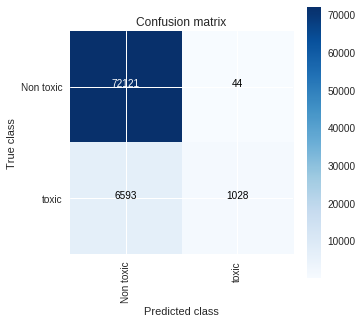

             precision    recall  f1-score   support

  Non toxic       0.92      1.00      0.96     72165
      toxic       0.96      0.13      0.24      7621

avg / total       0.92      0.92      0.89     79786

Confusion matrix, without normalization
[[79000     4]
 [  778     4]]


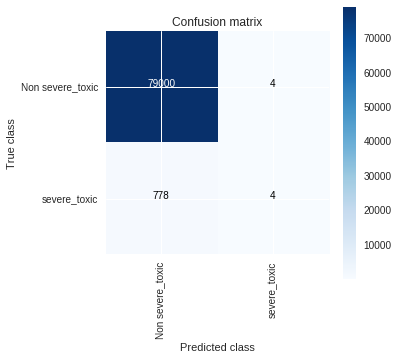

                  precision    recall  f1-score   support

Non severe_toxic       0.99      1.00      1.00     79004
    severe_toxic       0.50      0.01      0.01       782

     avg / total       0.99      0.99      0.99     79786

Confusion matrix, without normalization
[[75562    32]
 [ 3786   406]]


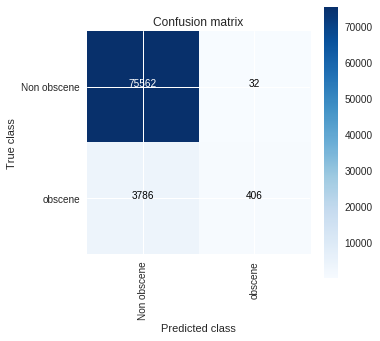

             precision    recall  f1-score   support

Non obscene       0.95      1.00      0.98     75594
    obscene       0.93      0.10      0.18      4192

avg / total       0.95      0.95      0.93     79786

Confusion matrix, without normalization
[[79564     0]
 [  222     0]]


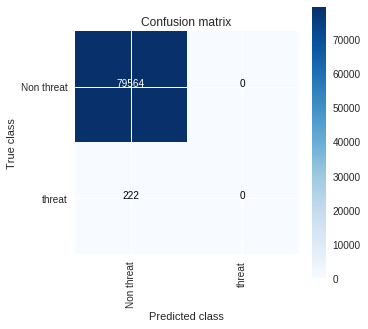

             precision    recall  f1-score   support

 Non threat       1.00      1.00      1.00     79564
     threat       0.00      0.00      0.00       222

avg / total       0.99      1.00      1.00     79786



/usr/local/lib/python3.4/dist-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Confusion matrix, without normalization
[[75925    40]
 [ 3639   182]]


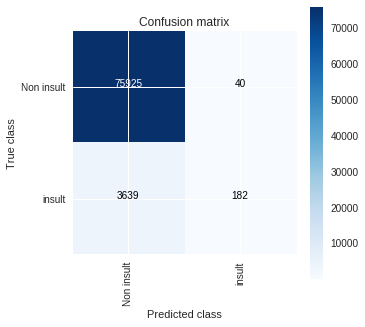

             precision    recall  f1-score   support

 Non insult       0.95      1.00      0.98     75965
     insult       0.82      0.05      0.09      3821

avg / total       0.95      0.95      0.93     79786

Confusion matrix, without normalization
[[79111     1]
 [  668     6]]


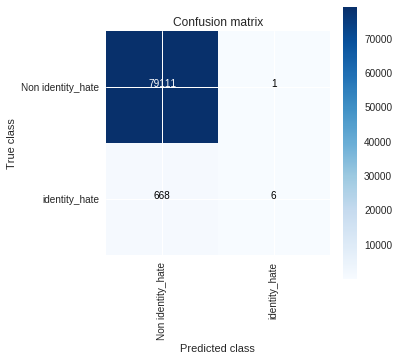

                   precision    recall  f1-score   support

Non identity_hate       0.99      1.00      1.00     79112
    identity_hate       0.86      0.01      0.02       674

      avg / total       0.99      0.99      0.99     79786



In [10]:
print_confusion_matrix_and_plot(y_test, predictions_int, output_classes)

### Area Under Curve ROC

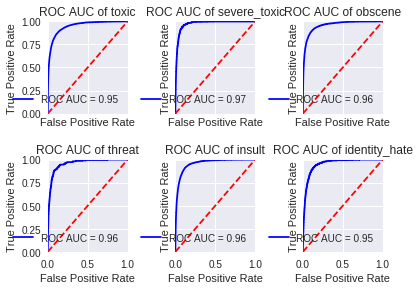

In [11]:
plot_auc_roc(output_classes, y_test, predictions, auc_roc_nb)

## Support Vector Machine Model


### Predictions

In [12]:
start_time = time.time()
vectorizer = TfidfVectorizer(sublinear_tf=True, norm='l2')
X_train_vect = vectorizer.fit_transform(X_train)

X_test_vect = vectorizer.transform(X_test)

svm = LinearSVC(C=0.12)
classifier = CalibratedClassifierCV(svm)

auc_roc_svm, predictions, predictions_int = calculate_predictions(classifier, X_train_vect, X_test_vect, y_train, y_test, output_classes)
end_time = time.time()
total_time_svm = end_time - start_time
print("\nExecution time: ", total_time_svm, "seconds")


Class:  toxic
ROC AUC:  0.9727658434636912

Class:  severe_toxic
ROC AUC:  0.9848012163196502

Class:  obscene
ROC AUC:  0.9876500839180662

Class:  threat
ROC AUC:  0.9907157012474744

Class:  insult
ROC AUC:  0.9791394620310014

Class:  identity_hate
ROC AUC:  0.9752703825519649

Multi-class ROC AUC:  0.9817237815886415

Execution time:  16.545900583267212 seconds


### Confusion Matrix

Confusion matrix, without normalization
[[71326   839]
 [ 2369  5252]]


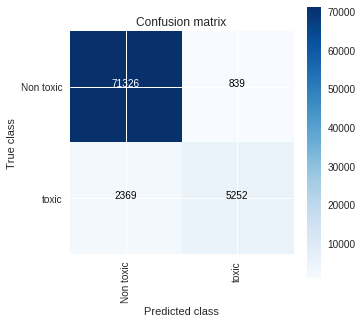

             precision    recall  f1-score   support

  Non toxic       0.97      0.99      0.98     72165
      toxic       0.86      0.69      0.77      7621

avg / total       0.96      0.96      0.96     79786

Confusion matrix, without normalization
[[78830   174]
 [  564   218]]


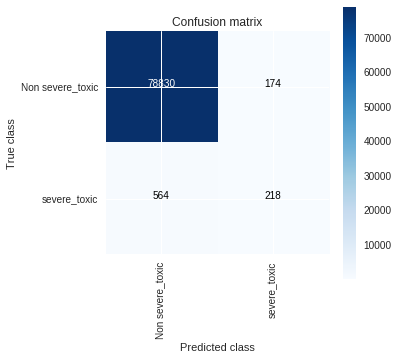

                  precision    recall  f1-score   support

Non severe_toxic       0.99      1.00      1.00     79004
    severe_toxic       0.56      0.28      0.37       782

     avg / total       0.99      0.99      0.99     79786

Confusion matrix, without normalization
[[75171   423]
 [ 1118  3074]]


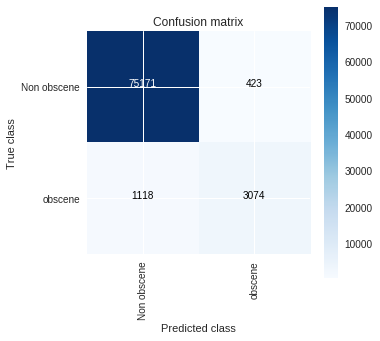

             precision    recall  f1-score   support

Non obscene       0.99      0.99      0.99     75594
    obscene       0.88      0.73      0.80      4192

avg / total       0.98      0.98      0.98     79786

Confusion matrix, without normalization
[[79502    62]
 [  161    61]]


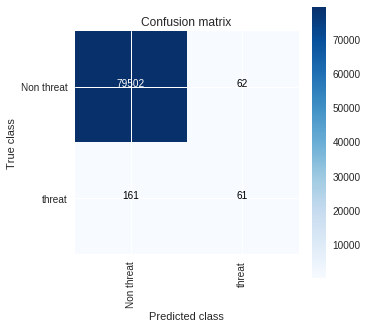

             precision    recall  f1-score   support

 Non threat       1.00      1.00      1.00     79564
     threat       0.50      0.27      0.35       222

avg / total       1.00      1.00      1.00     79786

Confusion matrix, without normalization
[[75358   607]
 [ 1503  2318]]


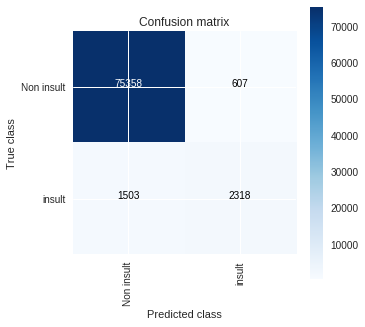

             precision    recall  f1-score   support

 Non insult       0.98      0.99      0.99     75965
     insult       0.79      0.61      0.69      3821

avg / total       0.97      0.97      0.97     79786

Confusion matrix, without normalization
[[78982   130]
 [  461   213]]


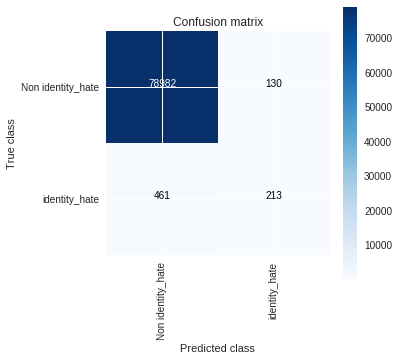

                   precision    recall  f1-score   support

Non identity_hate       0.99      1.00      1.00     79112
    identity_hate       0.62      0.32      0.42       674

      avg / total       0.99      0.99      0.99     79786



In [13]:
print_confusion_matrix_and_plot(y_test, predictions_int, output_classes)

In [14]:
for y_true, y_pred, comment in zip(y_test['threat'], predictions_int[:, 3], X_test):
    if(y_true == 0 and y_pred == 1):
        print("\n\n", comment)



 oh god  why don t you just fuck of and die of gaids   


 grandma terri should burn alive and be shot    get shot asshole g mau    fuck grandma terri in her old ass  grandma terri  i hope you die soon  fuck you in the eye  i hate you  i want to shoot your ass  grandma terri                 grandma terri  you are shit    grandma terri  i wish you die    die and go to hell  grandma terri            


 lo er   no one likes you  go kill yourself


 they will die and none of them will block me again  hell hell hell hell hell crap 


 fuck off mexican bastard  i will work endelessly to have your wikipedia account banned indefinitely  you have made my life a misery and i hope you die 


 important note i would also like to point out that i hate you aswell and  hope you die  best regards 


 do you know what i say gas the mother fucking jews   anhero kill yourself drink bleachanhero kill yourself drink bleachanhero kill yourself drink bleachanhero kill yourself drink bleachanhero kill your

### Area Under Curve ROC

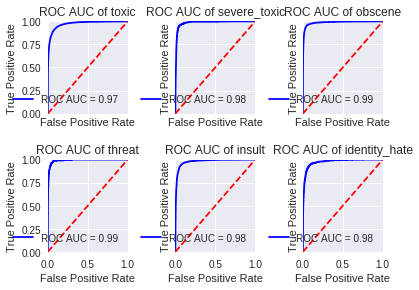

In [15]:
plot_auc_roc(output_classes, y_test, predictions, auc_roc_svm)

## Stochastic Gradient Descent Classifier Model

In [16]:
start_time = time.time()
vectorizer = TfidfVectorizer(sublinear_tf=True)
X_train_vect = vectorizer.fit_transform(X_train)

X_test_vect = vectorizer.transform(X_test)

classifier = SGDClassifier(loss='log', penalty='l2', alpha=0.000004)

auc_roc_sgd, predictions, predictions_int = calculate_predictions(classifier, X_train_vect, X_test_vect, y_train, y_test, output_classes)
end_time = time.time()
total_time_sgd = end_time - start_time
print("\nExecution time: ", total_time_sgd, "seconds")

/usr/local/lib/python3.4/dist-packages/sklearn/linear_model/stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)



Class:  toxic
ROC AUC:  0.9721863294719462

Class:  severe_toxic
ROC AUC:  0.9850974880225559

Class:  obscene
ROC AUC:  0.9856148858925353

Class:  threat
ROC AUC:  0.9889524881323936

Class:  insult
ROC AUC:  0.9775659746884425

Class:  identity_hate
ROC AUC:  0.9754108324958972

Multi-class ROC AUC:  0.9808046664506285

Execution time:  10.7253999710083 seconds


### Confusion Matrix

Confusion matrix, without normalization
[[71549   616]
 [ 2646  4975]]


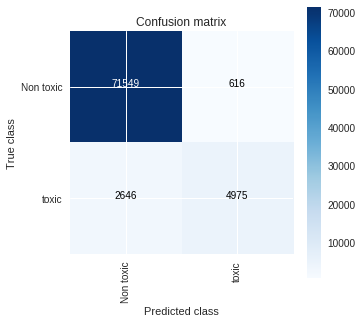

             precision    recall  f1-score   support

  Non toxic       0.96      0.99      0.98     72165
      toxic       0.89      0.65      0.75      7621

avg / total       0.96      0.96      0.96     79786

Confusion matrix, without normalization
[[78856   148]
 [  583   199]]


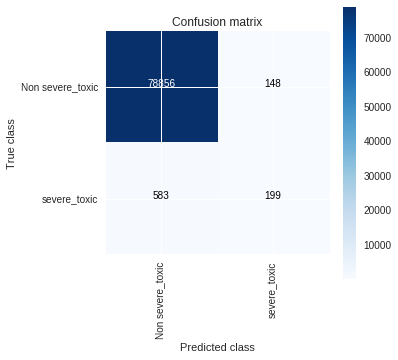

                  precision    recall  f1-score   support

Non severe_toxic       0.99      1.00      1.00     79004
    severe_toxic       0.57      0.25      0.35       782

     avg / total       0.99      0.99      0.99     79786

Confusion matrix, without normalization
[[75262   332]
 [ 1317  2875]]


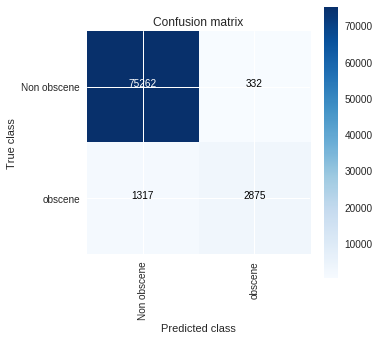

             precision    recall  f1-score   support

Non obscene       0.98      1.00      0.99     75594
    obscene       0.90      0.69      0.78      4192

avg / total       0.98      0.98      0.98     79786

Confusion matrix, without normalization
[[79536    28]
 [  179    43]]


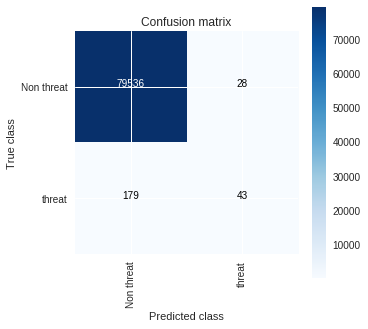

             precision    recall  f1-score   support

 Non threat       1.00      1.00      1.00     79564
     threat       0.61      0.19      0.29       222

avg / total       1.00      1.00      1.00     79786

Confusion matrix, without normalization
[[75406   559]
 [ 1601  2220]]


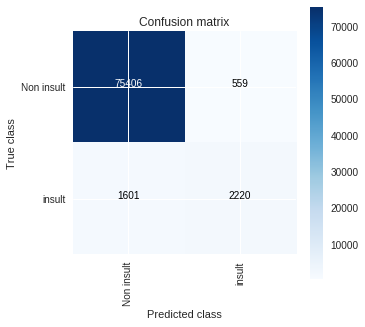

             precision    recall  f1-score   support

 Non insult       0.98      0.99      0.99     75965
     insult       0.80      0.58      0.67      3821

avg / total       0.97      0.97      0.97     79786

Confusion matrix, without normalization
[[79033    79]
 [  520   154]]


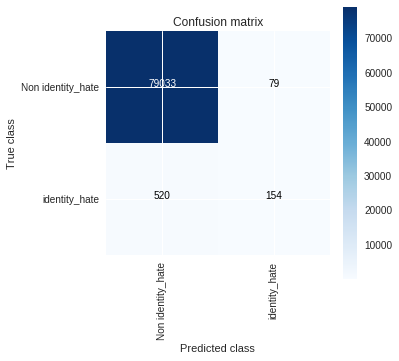

                   precision    recall  f1-score   support

Non identity_hate       0.99      1.00      1.00     79112
    identity_hate       0.66      0.23      0.34       674

      avg / total       0.99      0.99      0.99     79786



In [17]:
print_confusion_matrix_and_plot(y_test, predictions_int, output_classes)

### Area Under Curve ROC

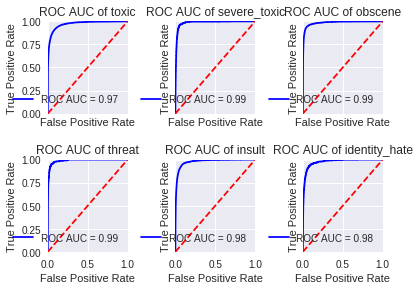

In [18]:
plot_auc_roc(output_classes, y_test, predictions, auc_roc_sgd)

## Extreme Gradient Boosting Tree Model


/usr/local/lib/python3.4/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Class:  toxic
ROC AUC:  0.7643629160393477


/usr/local/lib/python3.4/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Class:  severe_toxic
ROC AUC:  0.84526378346475


/usr/local/lib/python3.4/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Class:  obscene
ROC AUC:  0.7728880049902986


/usr/local/lib/python3.4/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Class:  threat
ROC AUC:  0.8093787096885231


/usr/local/lib/python3.4/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:



Class:  insult
ROC AUC:  0.7685245703570873

Class:  identity_hate
ROC AUC:  0.7347624657436417

Multi-class ROC AUC:  0.7825300750472749

Execution time:  56.283751487731934 seconds


/usr/local/lib/python3.4/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


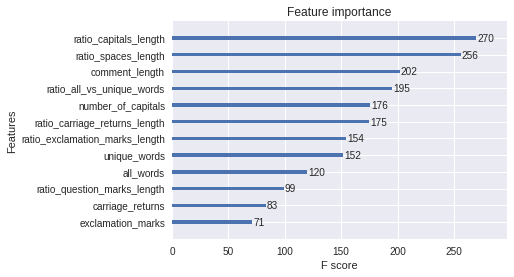

In [19]:
start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(train[new_features], 
                                                    train[output_classes], 
                                                    random_state=45, 
                                                    test_size=0.50)

params = {
    'n_estimators': 300,
    'objective': 'binary:logistic',
    'learning_rate': 0.1,
    'subsample': 0.5,
    'colsample_bytree': 0.5,
    'eval_metric': 'auc',
    'seed': 1024
}

classifier = xgb.XGBClassifier(**params)

auc_roc_xgb, predictions, predictions_int = calculate_predictions(classifier, X_train, X_test, y_train, y_test, output_classes)
end_time = time.time()
total_time_xgb = end_time - start_time
print("\nExecution time: ", total_time_xgb, "seconds")

xgb.plot_importance(classifier)
plt.show()

### Confusion Matrix

Confusion matrix, without normalization
[[71538   627]
 [ 6583  1038]]


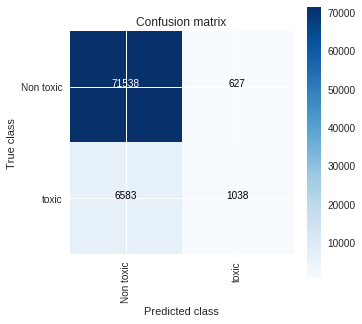

             precision    recall  f1-score   support

  Non toxic       0.92      0.99      0.95     72165
      toxic       0.62      0.14      0.22      7621

avg / total       0.89      0.91      0.88     79786

Confusion matrix, without normalization
[[78971    33]
 [  753    29]]


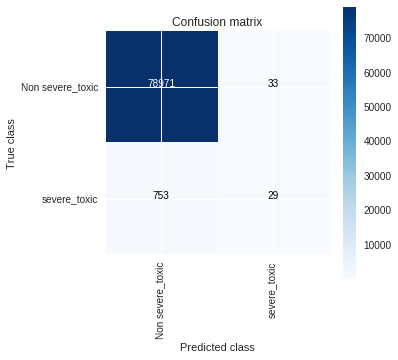

                  precision    recall  f1-score   support

Non severe_toxic       0.99      1.00      1.00     79004
    severe_toxic       0.47      0.04      0.07       782

     avg / total       0.99      0.99      0.99     79786

Confusion matrix, without normalization
[[75348   246]
 [ 3976   216]]


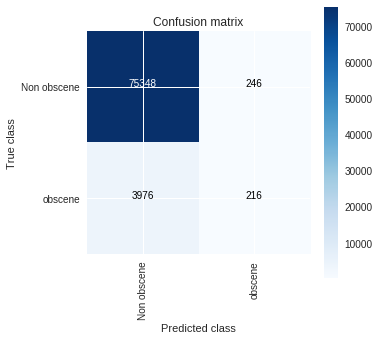

             precision    recall  f1-score   support

Non obscene       0.95      1.00      0.97     75594
    obscene       0.47      0.05      0.09      4192

avg / total       0.92      0.95      0.93     79786

Confusion matrix, without normalization
[[79561     3]
 [  220     2]]


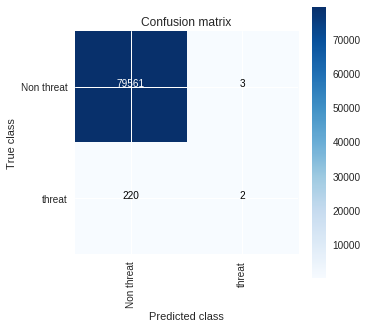

             precision    recall  f1-score   support

 Non threat       1.00      1.00      1.00     79564
     threat       0.40      0.01      0.02       222

avg / total       1.00      1.00      1.00     79786

Confusion matrix, without normalization
[[75765   200]
 [ 3677   144]]


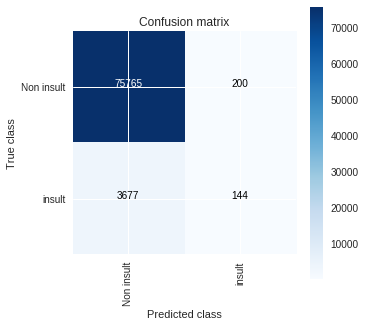

             precision    recall  f1-score   support

 Non insult       0.95      1.00      0.98     75965
     insult       0.42      0.04      0.07      3821

avg / total       0.93      0.95      0.93     79786

Confusion matrix, without normalization
[[79103     9]
 [  673     1]]


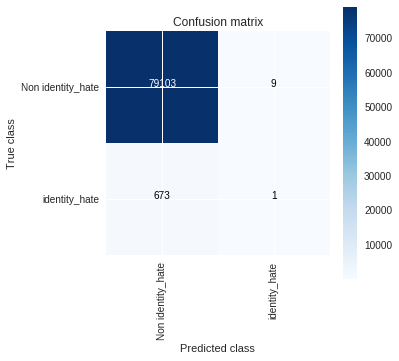

                   precision    recall  f1-score   support

Non identity_hate       0.99      1.00      1.00     79112
    identity_hate       0.10      0.00      0.00       674

      avg / total       0.98      0.99      0.99     79786



In [20]:
print_confusion_matrix_and_plot(y_test, predictions_int, output_classes)

### Area Under Curve ROC

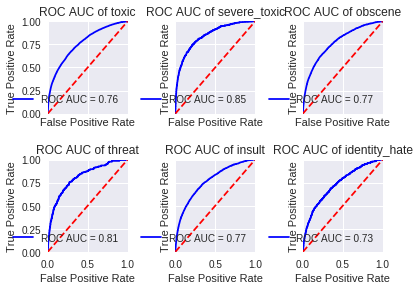

In [21]:
plot_auc_roc(output_classes, y_test, predictions, auc_roc_xgb)

## Random Forest Model

In [22]:
start_time = time.time()
X_train, X_test, y_train, y_test = train_test_split(train[new_features], 
                                                    train[output_classes], 
                                                    random_state=45, 
                                                    test_size=0.50)
params = {
    'n_estimators': 700,
    'criterion': 'entropy'
}

classifier = RandomForestClassifier(**params)

auc_roc_rf, predictions, predictions_int = calculate_predictions(classifier, X_train, X_test, y_train, y_test, output_classes)
end_time = time.time()
total_time_rf = end_time - start_time
print("\nExecution time: ", total_time_rf, "seconds")


Class:  toxic
ROC AUC:  0.7192869325936122

Class:  severe_toxic
ROC AUC:  0.768016529254694

Class:  obscene
ROC AUC:  0.7226592818086858

Class:  threat
ROC AUC:  0.6875783832699021

Class:  insult
ROC AUC:  0.7166232424321501

Class:  identity_hate
ROC AUC:  0.6589500934407532

Multi-class ROC AUC:  0.7121857437999662

Execution time:  857.8475501537323 seconds


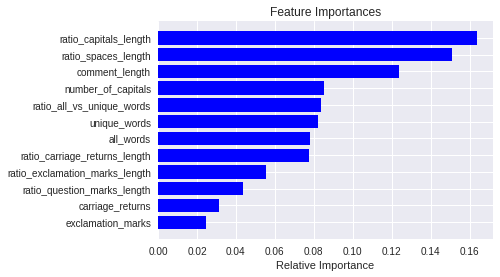

In [23]:
importances = classifier.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.xlabel('Relative Importance')
plt.yticks(range(len(indices)), [new_features[i] for i in indices])
plt.show()

### Confusion Matrix

Confusion matrix, without normalization
[[70909  1256]
 [ 6416  1205]]


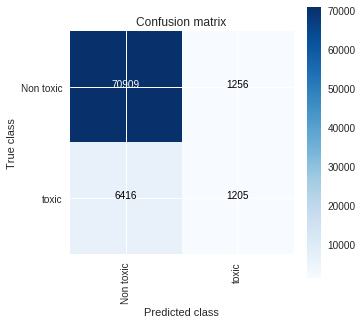

             precision    recall  f1-score   support

  Non toxic       0.92      0.98      0.95     72165
      toxic       0.49      0.16      0.24      7621

avg / total       0.88      0.90      0.88     79786

Confusion matrix, without normalization
[[78936    68]
 [  752    30]]


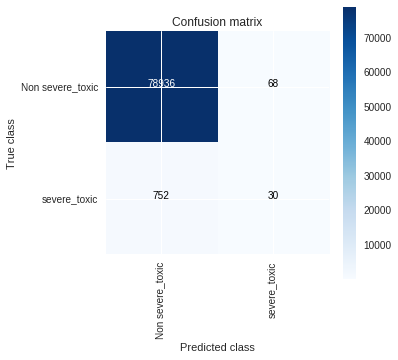

                  precision    recall  f1-score   support

Non severe_toxic       0.99      1.00      0.99     79004
    severe_toxic       0.31      0.04      0.07       782

     avg / total       0.98      0.99      0.99     79786

Confusion matrix, without normalization
[[75042   552]
 [ 3904   288]]


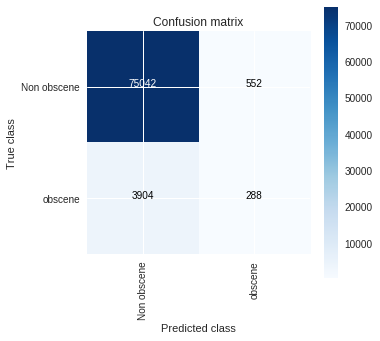

             precision    recall  f1-score   support

Non obscene       0.95      0.99      0.97     75594
    obscene       0.34      0.07      0.11      4192

avg / total       0.92      0.94      0.93     79786

Confusion matrix, without normalization
[[79557     7]
 [  220     2]]


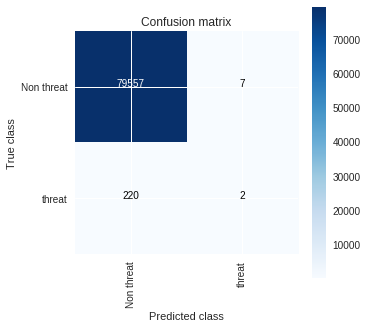

             precision    recall  f1-score   support

 Non threat       1.00      1.00      1.00     79564
     threat       0.22      0.01      0.02       222

avg / total       1.00      1.00      1.00     79786

Confusion matrix, without normalization
[[75474   491]
 [ 3605   216]]


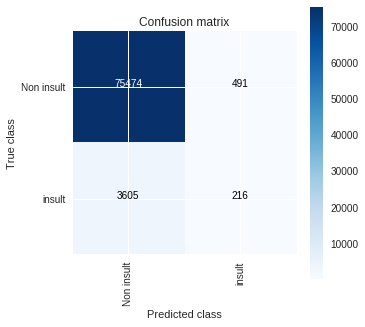

             precision    recall  f1-score   support

 Non insult       0.95      0.99      0.97     75965
     insult       0.31      0.06      0.10      3821

avg / total       0.92      0.95      0.93     79786

Confusion matrix, without normalization
[[79060    52]
 [  673     1]]


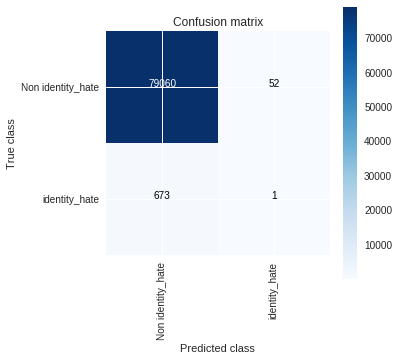

                   precision    recall  f1-score   support

Non identity_hate       0.99      1.00      1.00     79112
    identity_hate       0.02      0.00      0.00       674

      avg / total       0.98      0.99      0.99     79786



In [24]:
print_confusion_matrix_and_plot(y_test, predictions_int, output_classes)

### Area Under Curve ROC

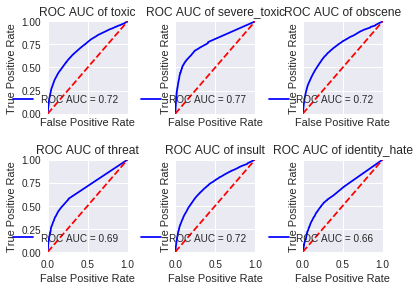

In [25]:
plot_auc_roc(output_classes, y_test, predictions, auc_roc_rf)

# Conclusion

## Summary of Models
We show the AUROC scores obtained from models we tested.

In [26]:
models = {
    'Model': ['Linear SVM Regularized', 'Stochastic Gradient Descent', 'Multinomial Naive Bayes', 'Extreme Gradient Boosting Tree', 'Random Forest'],
    'Score': [np.mean(auc_roc_svm), np.mean(auc_roc_sgd), np.mean(auc_roc_nb), np.mean(auc_roc_xgb), np.mean(auc_roc_rf)],
    'Time': [total_time_svm, total_time_sgd, total_time_nb, total_time_xgb, total_time_rf]
}
summary = pandas.DataFrame(models)
display(summary)

,Model,Score,Time
0,Linear SVM Regularized,0.981723782,16.545900583
1,Stochastic Gradient Descent,0.980804666,10.725399971
2,Multinomial Naive Bayes,0.957018842,9.688201666
3,Extreme Gradient Boosting Tree,0.782530075,56.283751488
4,Random Forest,0.712185744,857.847550154


From the scores of models, we select the Linear SVM Regularized classifier model to predict the real test set.

## Perspective Model vs Best Model
The goal is to test our model on the Perspective datasets and compare our AUC ROC with the Perspective model ones to verify if our best model fulfill the objective of this project. This means that our model has to give a better AUC ROC score than the Perspective model.

In the notebook https://github.com/conversationai/unintended-ml-bias-analysis/blob/master/unintended_ml_bias/Evaluate%20Models%20Across%20Datasets.ipynb, we see that their best score is done on the debias_random_model which obtained a ROCAUC of 0.972542.

In [27]:
train_rnd_perspective = pandas.read_csv("dataset/wiki_debias_random_train.csv")
train_rnd_perspective = clean(train_rnd_perspective)

test_rnd_perspective = pandas.read_csv("dataset/wiki_debias_random_test.csv")
test_rnd_perspective = clean(test_rnd_perspective)

dev_rnd_perspective = pandas.read_csv("dataset/wiki_debias_random_dev.csv")
dev_rnd_perspective = clean(dev_rnd_perspective)

In [28]:
train_perspective = pandas.read_csv("dataset/wiki_train.csv")
train_perspective = clean(train_perspective)

test_perspective = pandas.read_csv("dataset/wiki_test.csv")
test_perspective = clean(test_perspective)

dev_perspective = pandas.read_csv("dataset/wiki_dev.csv")
dev_perspective = clean(dev_perspective)

In [29]:
apply_best_model('Wiki Debias Random Test', train_rnd_perspective, test_rnd_perspective)
apply_best_model('Wiki Debias Random Dev', train_rnd_perspective, dev_rnd_perspective)

Wiki Debias Random Test AUC ROC:  0.9751467703260143
Wiki Debias Random Dev AUC ROC:  0.9739739332653962


In [30]:
apply_best_model('Wiki Test', train_perspective, test_perspective)
apply_best_model('Wiki Dev', train_perspective, dev_perspective)

Wiki Test AUC ROC:  0.9744905761181268
Wiki Dev AUC ROC:  0.9732874559506474


This is enough to show that our model is better than the Perspective's current models. The objectif is then fulfilled.

## Best Model Predictions
From the AUROC score we got, the support vector machine is the best one. Therefore, we use this model to get the prediction probabilities of each class using the comments from the test set.

In [31]:
vectorizer = TfidfVectorizer(sublinear_tf=True)
X_train_vect = vectorizer.fit_transform(train.comment_text)
X_test_vect = vectorizer.transform(test.comment_text)

svm = LinearSVC(C=0.12)
classifier = CalibratedClassifierCV(svm)

submission = pandas.read_csv('dataset/sample_submission.csv')

for i, output_class in enumerate(output_classes): 
    ## Training from the train set data.
    classifier.fit(X_train_vect, train[output_class])

    ## From what's learned when training, predict the class of each comment of the test set. 
    submission[output_class] = classifier.predict_proba(X_test_vect)[:, 1]

print(submission[output_classes])

             toxic  severe_toxic     obscene      threat      insult  \
0      0.999971472   0.128547014 0.999780194 0.019062572 0.982174675   
1      0.003172159   0.001740361 0.002534878 0.000357736 0.004639392   
2      0.023961611   0.004693653 0.012005726 0.000968965 0.015170119   
3      0.002363576   0.003589101 0.003472929 0.001059903 0.006016317   
4      0.016020127   0.002378412 0.005855621 0.001339387 0.007725040   
5      0.004634133   0.001894390 0.004197629 0.000812872 0.009307607   
6      0.003122302   0.000840731 0.004618959 0.000307620 0.006960938   
7      0.515293792   0.001855882 0.018313243 0.001348584 0.054983556   
8      0.011664737   0.002016407 0.006510815 0.000659524 0.008057193   
9      0.002261111   0.000877943 0.003909395 0.000623779 0.005349244   
10     0.440676014   0.000484673 0.082255585 0.000318530 0.005513739   
11     0.166727678   0.001916208 0.020124161 0.002000084 0.014869287   
12     0.002838098   0.001645479 0.003147785 0.000468317 0.00315

## Submission of Results

In [32]:
submission.to_csv('submission_SVM.csv', index=False)